<a href="https://colab.research.google.com/github/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/blob/main/Criando_um_Sistema_de_Reconhecimento_Facial_do_Zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as bilbiotecas
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from keras.models import load_model

In [2]:
# Função que converte objeto JavaScript em imagem OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Função que converte imagem delimitadora retangular em string base64 bytes para ser sobreposta no vídeo stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [3]:
# Inicializa o Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [4]:
# Modelo treinado pelo Teachable Machine
!wget https://github.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/raw/main/keras_model.h5

--2025-04-09 20:52:34--  https://github.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/raw/main/keras_model.h5
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/main/keras_model.h5 [following]
--2025-04-09 20:52:34--  https://raw.githubusercontent.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/main/keras_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2453432 (2.3M) [application/octet-stream]
Saving to: ‘keras_model.h5’

keras_model.h5      100%[===================>]   2.34M  --.-KB/s

In [24]:
# Classes
!wget https://github.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/raw/main/labels.txt
class_names = open("labels.txt", "r").readlines()

classes = ['Dwayne Johnson', 'Robert Downey Jr.']

--2025-04-09 21:02:45--  https://github.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/raw/main/labels.txt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/main/labels.txt [following]
--2025-04-09 21:02:45--  https://raw.githubusercontent.com/YukioChinen/Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/main/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39 [text/plain]
Saving to: ‘labels.txt’

labels.txt          100%[===================>]      39  --.-KB/s    in 0s      

2025-04-09 21:02:45 (1.33

In [25]:
# Importando o modelo do Keras

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.layers import DepthwiseConv2D

# Define a custom DepthwiseConv2D class to handle the "groups" argument
class CustomDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        # Remove the "groups" argument if present
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.pop('groups', None)  # Remove "groups" from the config
        return config

# Load the model with the custom object
model = load_model('keras_model.h5', compile=False, custom_objects={'DepthwiseConv2D': CustomDepthwiseConv2D})

data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

In [26]:
# Função para obter imagem da webcam

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      #Classificando a face
      recorte = img[y:y +h,x:x+ w]

      imgItem = cv2.resize(recorte, (224, 224), interpolation=cv2.INTER_AREA)
      imgItemArray = np.asarray(imgItem, dtype=np.float32).reshape(1, 224, 224, 3)
      imgItemNormalize = (imgItemArray / 127.5) - 1
      prediction = model.predict(imgItemNormalize)
      index = np.argmax(prediction)
      class_name = classes[index]
      percent = prediction[0][index]

      #Imprimindo na imagem
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
      pred_resultado = str(class_name) + ' - ' + str(percent)
      cv2.rectangle(img,(x,y+5),(x+h,y-20),(255,255,255),-1)
      cv2.putText(img,pred_resultado.upper(),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Saved to photo.jpg


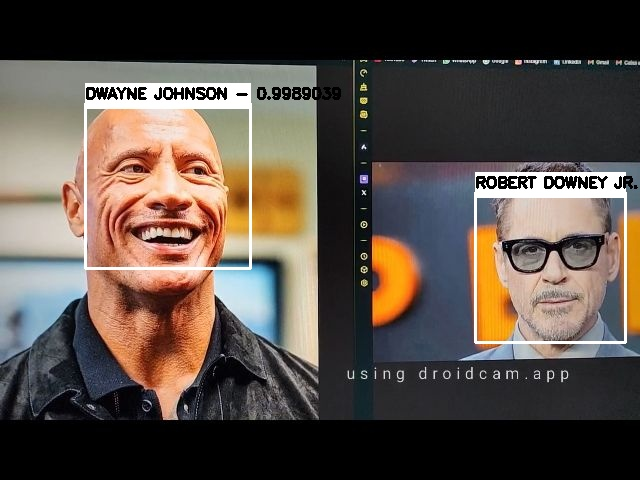

In [33]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))